In [1]:
# Setup and Import
"""
Baseline Model Training
=======================
Train and compare baseline models for fraud detection
"""

import sys
sys.path.append('..')
import os
os.chdir('..') # Go to project root

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Import our modules
from src.data.loader import DataLoader
from src.features.engineer import FeatureEngineer
from src.models.train import ModelTrainer

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')

print("Imports complete!")

Imports complete!


In [4]:
# Load and prepare data
# Load raw data
loader = DataLoader()
df = loader.load_data()

# Apply feature enginering
print("\nEngineering features...")
engineer = FeatureEngineer()
df_engineered = engineer.fit_transform(df)

print(f"Features ready: {df_engineered.shape[1] - 1} features (excluding target, including 'Time')")

# Quick check of new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"New features created: {new_features[:5]}... and {len(new_features)-5} more")

2025-09-28 23:00:34,367 - INFO - Loading data from data\raw\creditcard.csv


2025-09-28 23:00:37,528 - INFO - Data validation passed!
2025-09-28 23:00:37,533 - INFO - Loaded 284,807 transactions
2025-09-28 23:00:37,536 - INFO - Fraud rate: 0.17%
2025-09-28 23:00:37,542 - INFO - Memory usage: 67.4 MB
2025-09-28 23:00:37,613 - INFO - Fitted on 284807 samples.



Engineering features...


2025-09-28 23:00:38,525 - INFO - Created 40 total features.


Features ready: 41 features (excluding target, including 'Time')
New features created: ['Amount_log', 'Amount_scaled', 'Amount_bin', 'Amount_is_zero', 'Hour']... and 6 more


In [5]:
# Train Baseline Models
# Initialize trainer
trainer = ModelTrainer(random_state=42)

# Prepare data (split and scale)
X_train, X_test, y_train, y_test = trainer.prepare_data(df_engineered)

# Train models
print("Training models...")
models = trainer.train_baseline_models(X_train, X_test, y_train, y_test)

print("Training complete!")

2025-09-28 23:14:00,656 - INFO - Train set: 227845 samples, 0.17% fraud.
2025-09-28 23:14:00,658 - INFO - Test set: 56962 samples, 0.17% fraud
2025-09-28 23:14:01,174 - INFO - 
Class weight ratio: 577.3:1
2025-09-28 23:14:01,177 - INFO - 
Training Logistic Regression...


Training models...


2025-09-28 23:14:03,067 - INFO - Training Random Forest...
2025-09-28 23:14:33,756 - INFO - 
Evaluating Logistic Regression...
2025-09-28 23:14:33,893 - INFO - 
Evaluating Random Forest...



Logistic Regression Results:

Precision: 0.057 (Of predicted frauds, 5.7% were correct)
Recall: 0.918 (Caught 91.8% of actual frauds)
F1 Score: 0.107
ROC-AUC: 0.972

Confusion Matrix:
            Predicted
            Normal          Fraud
Normal       55366      1498
Fraud            8        90

Business Impact:
False alarms: 1498 legitimate transactions flagged
Missed fraud: 8 fraudulent transactions missed

Random Forest Results:

Precision: 0.828 (Of predicted frauds, 82.8% were correct)
Recall: 0.837 (Caught 83.7% of actual frauds)
F1 Score: 0.832
ROC-AUC: 0.978

Confusion Matrix:
            Predicted
            Normal          Fraud
Normal       56847        17
Fraud           16        82

Business Impact:
False alarms: 17 legitimate transactions flagged
Missed fraud: 16 fraudulent transactions missed
Training complete!


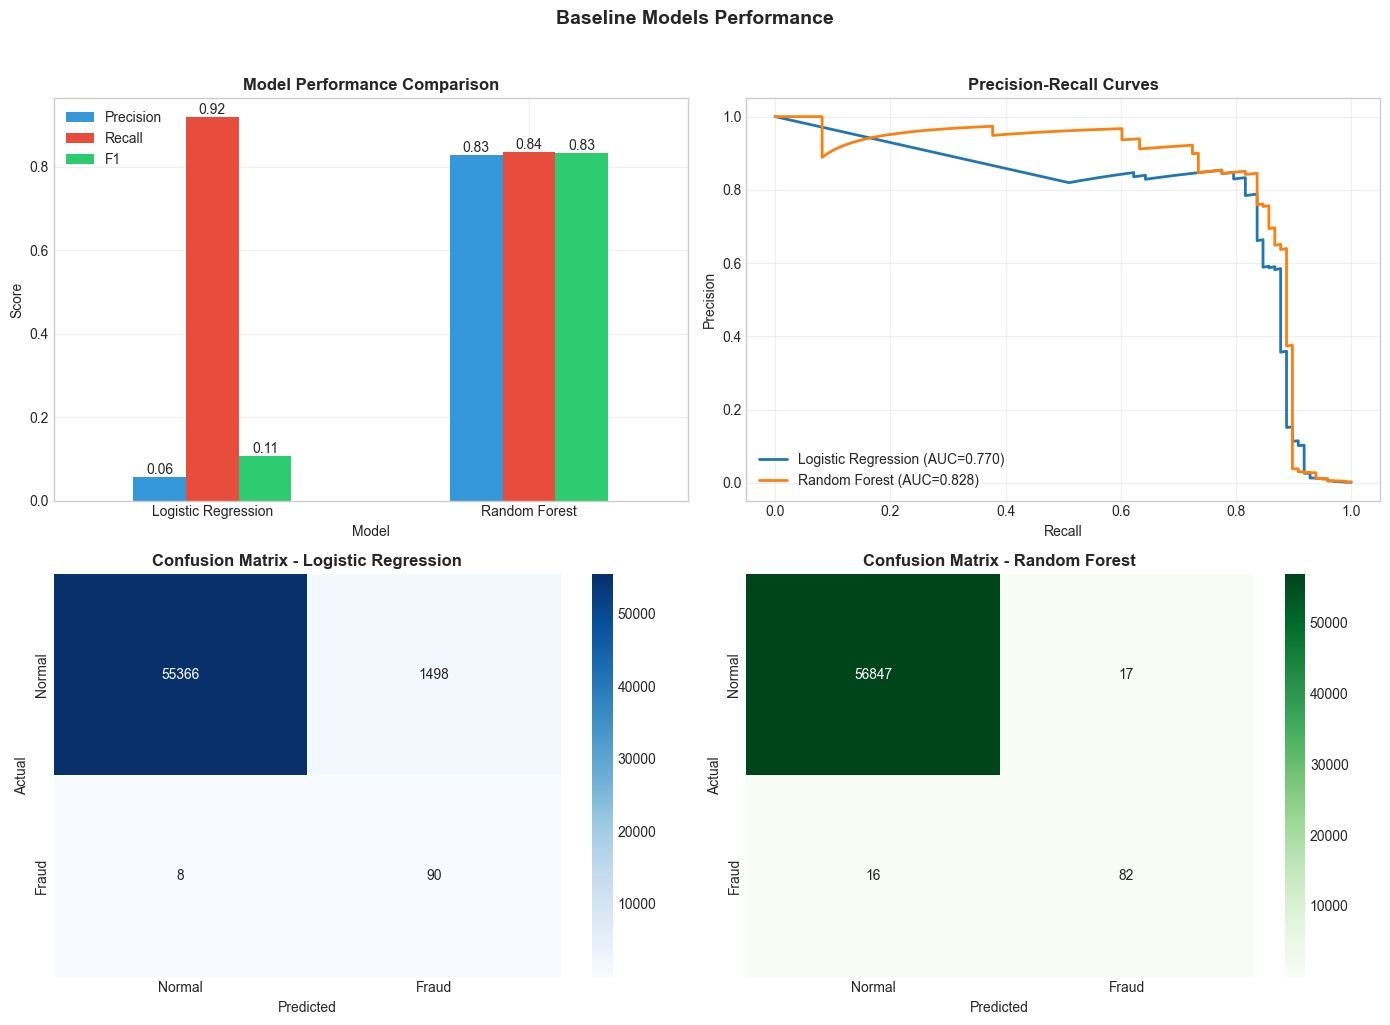


💼 BUSINESS IMPACT COMPARISON

Logistic Regression:
  ✅ Caught 90/98 frauds (91.8%)
  ⚠️  False alarms: 1,498 legitimate transactions flagged
  📊 Trade-off: 16.6 false alarms per fraud caught

Random Forest:
  ✅ Caught 82/98 frauds (83.7%)
  ⚠️  False alarms: 17 legitimate transactions flagged
  📊 Trade-off: 0.2 false alarms per fraud caught


In [ ]:
# Visualize Model Comparison
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Metrics Comparison Bar Chart
ax1 = axes[0, 0]
metrics_df = pd.DataFrame({
    model_name: {
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1']
    }
    for model_name, results in trainer.results.items()
})

metrics_df.T.plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c', '#2ecc71'])
ax1.set_title('Model Performance Comparison', fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Add value labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f')
    
# 2. Precision-Recall Curves
ax2 = axes[0, 1]
for model_name, results in trainer.results.items():
    precision, recall , _ = precision_recall_curve(y_test, results['probabilities'])
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.3f})', linewidth=2)
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Confusion Matrix - Logistic Regression
ax3 = axes[1, 0]
cm_lr = trainer.results['Logistic Regression']['confusion_matrix']
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
ax3.set_title('Confusion Matrix - Logistic Regression', fontweight='bold')
ax3.set_ylabel('Actual')
ax3.set_xlabel('Predicted')

# 4. Confusion Matrix Radom Forest
ax4 = axes[1, 1]
cm_rf = trainer.results['Random Forest']['confusion_matrix']
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax4,
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
ax4.set_title('Confusion Matrix - Random Forest', fontweight='bold')
ax4.set_ylabel('Actual')
ax4.set_xlabel('Predicted')

plt.suptitle('Baseline Models Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print business impact comparison
print("\n" + "="*60)
print("💼 BUSINESS IMPACT COMPARISON")
print("="*60)

for model_name, results in trainer.results.items():
    cm = results['confusion_matrix']
    total_fraud = cm[1, 0] + cm[1, 1]
    caught_fraud = cm[1, 1]
    false_alarms = cm[0, 1]
    
    print(f"\n{model_name}:")
    print(f"  ✅ Caught {caught_fraud}/{total_fraud} frauds ({caught_fraud/total_fraud*100:.1f}%)")
    print(f"  ⚠️ False alarms: {false_alarms:,} legitimate transactions flagged")
    print(f"  📊 Trade-off: {false_alarms/caught_fraud:.1f} false alarms per fraud caught")
